# Lab 11: Anonymization Using PCA

In [1]:
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics import mean_squared_error, r2_score

import matplotlib.pyplot as plt

In this lab we will use the same Scottish traffic dataset as last week. We'll preprocess it in the same way as we did last time. But in this week's lab we'll try a different approach to anonymization, this time using PCA. 

In [2]:
df = pd.read_csv('scotland-traffic.csv', parse_dates=['count_date'])

We will extract the month from the date and use that as a separate feature. We will also recode the road type. 

In [3]:
df['month'] = pd.DatetimeIndex(df['count_date']).month

In [4]:
df['road_type'] = df['road_type'] == 'Major'

We'll get rid of the records that are missing the outcome variable. And for now we'll replace all other missing values with 0. 

In [5]:
df = df[~df.all_motor_vehicles.isna()]
df.fillna(0, inplace=True)

In [6]:
df.head()

,year,count_date,hour,road_type,latitude,longitude,link_length_km,pedal_cycles,two_wheeled_motor_vehicles,buses_and_coaches,all_motor_vehicles,month
0,2005,2005-05-12,7,True,55.837029,-3.925646,8.4,0,2,10,3299,5
1,2005,2005-05-12,8,True,55.837029,-3.925646,8.4,0,4,5,2852,5
2,2005,2005-05-12,9,True,55.837029,-3.925646,8.4,0,4,18,2346,5
3,2005,2005-05-12,10,True,55.837029,-3.925646,8.4,0,10,17,2392,5
4,2005,2005-05-12,11,True,55.837029,-3.925646,8.4,0,4,12,1685,5


## Predicting Number of Motor Vehicles, Given Other Features (No Anonymization)

This section of the notebook is the same as last week, predicting 'all_motor_vehicles' with no data anonymization. 

In our first experiment, we'll try to predict the amount of motor vehicle traffic using all of the other features, with no anonymization of the data. 

In [7]:
features = ['year', 'hour', 'month', 'latitude', 'longitude', 'link_length_km', 'pedal_cycles', 'two_wheeled_motor_vehicles', 'buses_and_coaches', 'road_type']

X = df[features]

In [8]:
y = df['all_motor_vehicles']

We'll rescale all of the features so that they will all fall within a similar range. 

In [9]:
X = preprocessing.StandardScaler().fit_transform(X)

We'll use 2/3 of the data for training and 1/3 for testing. 

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

For now we'll use k-nearest neigbors regression. (yet another $k$ with yet another meaning)

This is a very simple regression model that is often effective. Basically when we want to predict the value of the outcome variable for a test example, we find its $k$ nearest neighbours in the training set and predict the average of their values. 

You could also use linear regression, or a multi-layer perceptron, or a random forest model, for example. 

In [11]:
knn = KNeighborsRegressor(n_neighbors=10)

In [12]:
knn.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=10)

In [13]:
preds = knn.predict(X_test)

We're going to report an evaluation metric called the R2 score (or r-squared metric). Basically a value close to 1 is good as it means the predictive model explains much of the variance in the outcome variable. 

In [14]:
r2_orig = r2_score(y_test, preds)
print('R2 Score (No Anonymization):', r2_orig)

R2 Score (No Anonymization): 0.7825568558823538


Not bad! We can compare the actual values with our predicted values. 

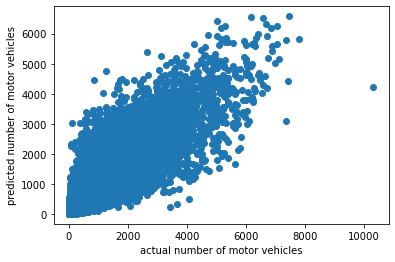

In [15]:
plt.figure()
plt.scatter(y_test, preds)
plt.xlabel('actual number of motor vehicles')
plt.ylabel('predicted number of motor vehicles')
plt.show()

# Predicting Number of Motor Vehicles (With PCA Anonymized Data)

Now we'll try anonymizing the data using principal components analysis (PCA), and then trying the same prediction tasks on the anonymized data. 

In [16]:
from sklearn.decomposition import PCA

We'll use the same features again, but now transforming them with PCA. We'll rescale them before doing PCA. 

In [17]:
features = ['year', 'hour', 'month', 'latitude', 'longitude', 'link_length_km', 'pedal_cycles', 'two_wheeled_motor_vehicles', 'buses_and_coaches', 'road_type']

X = df[features]
X = preprocessing.StandardScaler().fit_transform(X)

y = df['all_motor_vehicles']

In [18]:
print('shape before PCA')
print(X.shape)
    
# number of PCA components to retain
# e.g. first 5 principal components
num_comps = 5
    
pca = PCA(n_components=num_comps)
newX = pca.fit_transform(X)

print('shape after PCA')
print(newX.shape)   

print('\nhere we can see that each observation now has a score for each of the first n principal components:\n')
print(newX)

shape before PCA
(268860, 10)
shape after PCA
(268860, 5)

here we can see that each observation now has a score for each of the first n principal components:

[[ 1.52324673 -0.90352347 -0.63528338 -1.46037018  0.97697834]
 [ 1.56089203 -0.95037782 -0.56454799 -1.25981819  0.63827759]
 [ 2.14696675 -0.35957413 -0.40611985 -1.19903623  0.55378178]
 ...
 [ 1.39088876  0.1490738  -0.30162901 -0.89571171 -0.15223174]
 [ 1.38400853  0.05795864 -0.24157155 -0.68899496 -0.50348839]
 [ 1.70293011  0.38319747 -0.14721098 -0.59122441 -0.66331963]]


In [19]:
X_train, X_test, y_train, y_test = train_test_split(newX, y, test_size=0.33, random_state=42)

knn = KNeighborsRegressor(n_neighbors=10)
knn.fit(X_train, y_train)
preds_anon = knn.predict(X_test)

r2_anon = r2_score(y_test, preds_anon)
print('R2 Score (w/ PCA Anonymization):', r2_anon)

R2 Score (w/ PCA Anonymization): 0.6568925171839698


# Lab Assignment

Try the following:
   - Try different numbers of principal components to retain. See how the prediction performance on the anonymized data changes as you change the number of components. 
   - Try at least one other regression model other than k-nearest neighbors and see how it performs on this prediction task, both on the original data and on the anonymized data. You could use linear regression, or a multi-layer perceptron, or another regression model of your choice. 
   - When preprocessing the data, we replaced all missing values with 0. Change this so that each column has its missing values replaced with the median value of the column. See if this changes the performance of the prediction models. 

### Deliverables: Submit your completed notebook via Blackboard. 

In [20]:
num_comps = 7
    
pca = PCA(n_components=num_comps)
newX = pca.fit_transform(X)

print('shape after PCA')
print(newX.shape)   

print('\nhere we can see that each observation now has a score for each of the first n principal components:\n')
print(newX)

shape after PCA
(268860, 7)

here we can see that each observation now has a score for each of the first n principal components:

[[ 1.52324673 -0.90352347 -0.63528338 ...  0.97697834  0.09809186
   0.11870533]
 [ 1.56089203 -0.95037782 -0.56454799 ...  0.63827759 -0.02701955
   0.38415106]
 [ 2.14696675 -0.35957413 -0.40611985 ...  0.55378178 -0.10109222
   0.40969638]
 ...
 [ 1.39088876  0.1490738  -0.30162901 ... -0.15223174 -0.45573777
  -0.02134429]
 [ 1.38400853  0.05795864 -0.24157155 ... -0.50348839 -0.57612986
   0.24056643]
 [ 1.70293011  0.38319747 -0.14721098 ... -0.66331963 -0.62188668
   0.24490169]]


In [21]:
from sklearn import linear_model
X_train, X_test, y_train, y_test = train_test_split(newX, y, test_size=0.33, random_state=42)
lm = linear_model.LinearRegression()

lm.fit(X_train, y_train)

preds_anon = lm.predict(X_test)

r2_anon = r2_score(y_test, preds_anon)

print('R2 Score (With Anonymization with 7 components and Linear Regression):', r2_anon)

R2 Score (With Anonymization with 7 components and Linear Regression): 0.5911874111747557


In [22]:
num_comps = 3
    
pca = PCA(n_components=num_comps)
newX = pca.fit_transform(X)

print('shape after PCA')
print(newX.shape)   

print('\nhere we can see that each observation now has a score for each of the first n principal components:\n')
print(newX)

shape after PCA
(268860, 3)

here we can see that each observation now has a score for each of the first n principal components:

[[ 1.52324673 -0.90352347 -0.63528338]
 [ 1.56089203 -0.95037782 -0.56454799]
 [ 2.14696675 -0.35957413 -0.40611985]
 ...
 [ 1.39088876  0.1490738  -0.30162901]
 [ 1.38400853  0.05795864 -0.24157155]
 [ 1.70293011  0.38319747 -0.14721098]]


In [23]:
X_train, X_test, y_train, y_test = train_test_split(newX, y, test_size=0.33, random_state=42)
lm = linear_model.LinearRegression()

lm.fit(X_train, y_train)

preds_anon = lm.predict(X_test)

r2_anon = r2_score(y_test, preds_anon)

print('R2 Score (With Anonymization with 3 components and Linear Regression):', r2_anon)

R2 Score (With Anonymization with 3 components and Linear Regression): 0.42668331554169336


In [25]:
df = pd.read_csv('scotland-traffic.csv', parse_dates=['count_date'])
df['month'] = pd.DatetimeIndex(df['count_date']).month
df['road_type'] = df['road_type'] == 'Major'

In [28]:
df = df[~df.all_motor_vehicles.isna()]
df.fillna(df.median(numeric_only=True), inplace=True)

In [30]:
features = ['year', 'hour', 'month', 'latitude', 'longitude', 'link_length_km', 'pedal_cycles', 'two_wheeled_motor_vehicles', 'buses_and_coaches', 'road_type']
X = df[features]
X = preprocessing.StandardScaler().fit_transform(X)

y = df['all_motor_vehicles']

print('shape before PCA')
print(X.shape)

num_comps = 3
    
pca = PCA(n_components=num_comps)
newX = pca.fit_transform(X)

print('shape after PCA')
print(newX.shape)   

print('\nhere we can see that each observation now has a score for each of the first n principal components:\n')
print(newX)

X_train, X_test, y_train, y_test = train_test_split(newX, y, test_size=0.33, random_state=42)
lm = linear_model.LinearRegression()

lm.fit(X_train, y_train)

preds_anon = lm.predict(X_test)

r2_anon = r2_score(y_test, preds_anon)

print('R2 Score (With Anonymization with 3 components and Linear Regression with missing data values as median):', r2_anon)

shape before PCA
(268860, 10)
shape after PCA
(268860, 3)

here we can see that each observation now has a score for each of the first n principal components:

[[ 1.09877366 -1.23099484 -0.63153133]
 [ 1.12635002 -1.29074535 -0.56142759]
 [ 1.85360654 -0.92697774 -0.43956075]
 ...
 [ 1.43783418 -0.08524316 -0.28869   ]
 [ 1.41023623 -0.17220167 -0.22661972]
 [ 1.80644695  0.02831793 -0.15295365]]
R2 Score (With Anonymization with 3 components and Linear Regression with missing data values as median): 0.44547132562747216


We can see that as the number of components increased, the score increased. When we replaced the missing values with the median of the columns, we can see that the score improved by approximately 0.02 using the 3 components and linear regression.